In [2]:
import matplotlib.pyplot as plt
import requests
import numpy as np
import pickle
import gzip
import torch
import math

In [3]:
from copy import copy
from pathlib import Path
from matplotlib import pyplot as plt

In [4]:
def prepare_data():
    DATA_PATH = Path("data")
    PATH = DATA_PATH / "mnist"
 
    PATH.mkdir(parents=True, exist_ok=True)
 
    URL = "http://deeplearning.net/data/mnist/"
    FILENAME = "mnist.pkl.gz"
 
    if not (PATH / FILENAME).exists():
            content = requests.get(URL + FILENAME).content
            (PATH / FILENAME).open("wb").write(content)
 
    with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
            ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")
 
    x_train, y_train, x_valid, y_valid = map(
        torch.tensor, (x_train, y_train, x_valid, y_valid)
    )
   
    return x_train, y_train


In [5]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)
 
def model(xb):
    return log_softmax(xb @ y_weights + y_bias)
 
def nll(input_, target):
    return -input_[range(target.shape[0]), target].mean()
 
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [6]:
y_weights = torch.randn(784, 10) / math.sqrt(784)
y_weights.requires_grad_()
u_weights = torch.randn(784, 10) / math.sqrt(784)
u_weights.requires_grad_()
y_bias = torch.zeros(10, requires_grad=True)
u_bias = torch.zeros(10, requires_grad=True)
alpha_k = 0.01
A_k = 0.0
M_k = 2 # Change it later
L_k = 6 * M_k
max_iter = 100 # how many iters to train for

In [7]:
x_train, y_train = prepare_data()
loss_func = nll

In [8]:
losses_values = []
accuracy_values = []

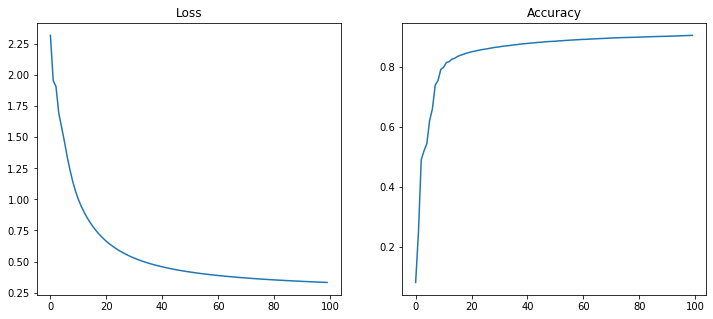

In [9]:
for iter_num in range(max_iter):
    pred = model(x_train)
    loss = loss_func(pred, y_train)
    accuracy_val = accuracy(pred, y_train)
   
    losses_values.append(loss)
    accuracy_values.append(accuracy_val)
   
    loss.backward()
    with torch.no_grad():
        alpha_k = (1 / L_k + np.sqrt(1 / L_k**2 + 4 * A_k / L_k))/2
        A_k_next = A_k + alpha_k
       
        x_weights = y_weights * A_k / A_k_next + u_weights * alpha_k / A_k_next
        x_bias = y_bias * A_k / A_k_next + u_bias * alpha_k / A_k_next
        y_weights.copy_(-y_weights.grad / M_k + x_weights)
        y_bias.copy_(-y_bias.grad / M_k + x_bias)
        u_weights.copy_(u_weights - alpha_k * y_weights.grad)
        u_bias.copy_(u_bias - alpha_k * y_bias.grad)
       
        y_weights.grad.zero_()
        y_bias.grad.zero_() 
        A_k = copy(A_k_next)
 
f, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].set_title("Loss")
ax[1].set_title("Accuracy")
ax[0].plot([losses_values[i].detach() for i in range(max_iter)])
ax[1].plot(accuracy_values)
plt.show()